<a href="https://colab.research.google.com/github/sgr1118/PyTorch/blob/main/Chapter10_%ED%99%95%EB%A5%A0%EC%A0%81_%EA%B2%BD%EC%82%AC%ED%95%98%EA%B0%95%EB%B2%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 10.1 확률적 경사하강법이란?
- 앞선 학습 방법에서 발생하는 문제는 크게 2가지이다. 첫 번째 GPU메모리 한계, 두 번째 학습 속도이다. 이는 딥러닝이 GPU가 병렬 계산을하기 때문이다. 이런 문제를 해소하기위하여 확률적 경사하강법을 사용한다. 
- SGD는 전체 데이터셋을 모델에 통과시키는 대신 랜덤 샘플링한 k개의 샘플을 모델에 통과시켜 손실 값을 계산한다. 이때 샘플링 과정은 비복원 추출이다.
- 한 번 학습한 사용한 샘플은 모든 샘플들이 학습에 활용되기 전까지 재사용되지않는다. 이처럼 샘플리하는 과정이 확률적으로 배치되기 때문에 확률적 경사하강법이라고한다. (교재 269p 그림 참고)
- 이렇게 전체 데이터셋의 샘플들이 전부 모델을 통과하는 것은 에포크(epoch)라고 부르며, 한 개의 미니배치를 모델에 통과시키는 것을 이터레이션(iteration)이라고 한다.
- $Iteration / Epoch = |\frac{N}{k}|$
- $Iteration = |\frac{N}{k}| \cdot Epoch$

- 위 식은 데이터셋 크기 : N, 파라미터 업데이트(이터레이터) 횟수, 에코프 횟수, 그리고 미니배치의 크기 k의 관계를 보여준다.
- k가 작아질수록 이터레이션의 횟수는 증가하고 또한 SGD를 구현하기 위해서는 자연스럽게 이중 for-loop가 만들어진다.

## 10.2 SGD의 직관적 이해
![](https://blog.kakaocdn.net/dn/b8RUdK/btqAm4Utey2/5DfjTQw70XKYgtOB8VHpeK/img.png)
<center>SGD 직관적 이해 그림</center>

- SGD가 최솟값을 찾을 때 저런 모양이 나오는 이유는 다음과 같다. 미니 배치는 어쩔 수 없이 편향을 발생시키기 때문이다. 중구난방한 모습이 비효율적이라고 느낄 수 있다. 하지만 SGD가 보통 경사하강법이 지역 최소점에 빠질때 이 부분을 탈출할 수 있다.

- 결론적으로 미니배치가 커질수록 그래디언트는 실제 그래디언트와 비슷해질 확률이 높고 작을수록 그래디언트는 실제 그래디언트와 달라질 확률이 높을 것이다.

## 10.3 미니배치 크기에 따른 SGD
- 앞서 10.2에서 미니 배치 크기에 따른 그래디언트 변화에 대하여 설명하였다. 배치 크기가 커질때는 실제 그래디언트에 가까워지지만 계산량이 그만큼 늘것이고 작을때는 전체 데이터셋의 손실 표면을 탈출할 수도있지만 너무 심한 노이즈가 생길 것이다. 보통 256정도 크기에서 시작하는 것이 좋다.

### 1. 미니배치 크기에 따른 파라미터 업데이트 횟수
- 결론적으로 무조건 적절한 미니 배치크기는 없다. 왜냐하면 배치 크기를 줄여서 이터레이션 숫자를 늘리면 노이즈가 생길 것이고 반대로 늘린다면 학습률을 크게 잡아 파라미터가 업데이트되는 양을 늘린다. 이는 경험적인 시도가 필요한 부분이다.

## 10.4 SGD 적용하기

In [1]:
# 라이브러리 불러오기

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 데이터 셋 불러오기

from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()

#print(cancer.DESCR)

# 보스턴 데이터 df

df = pd.DataFrame(california.data, columns = california.feature_names)
df['TARGET'] = california.target

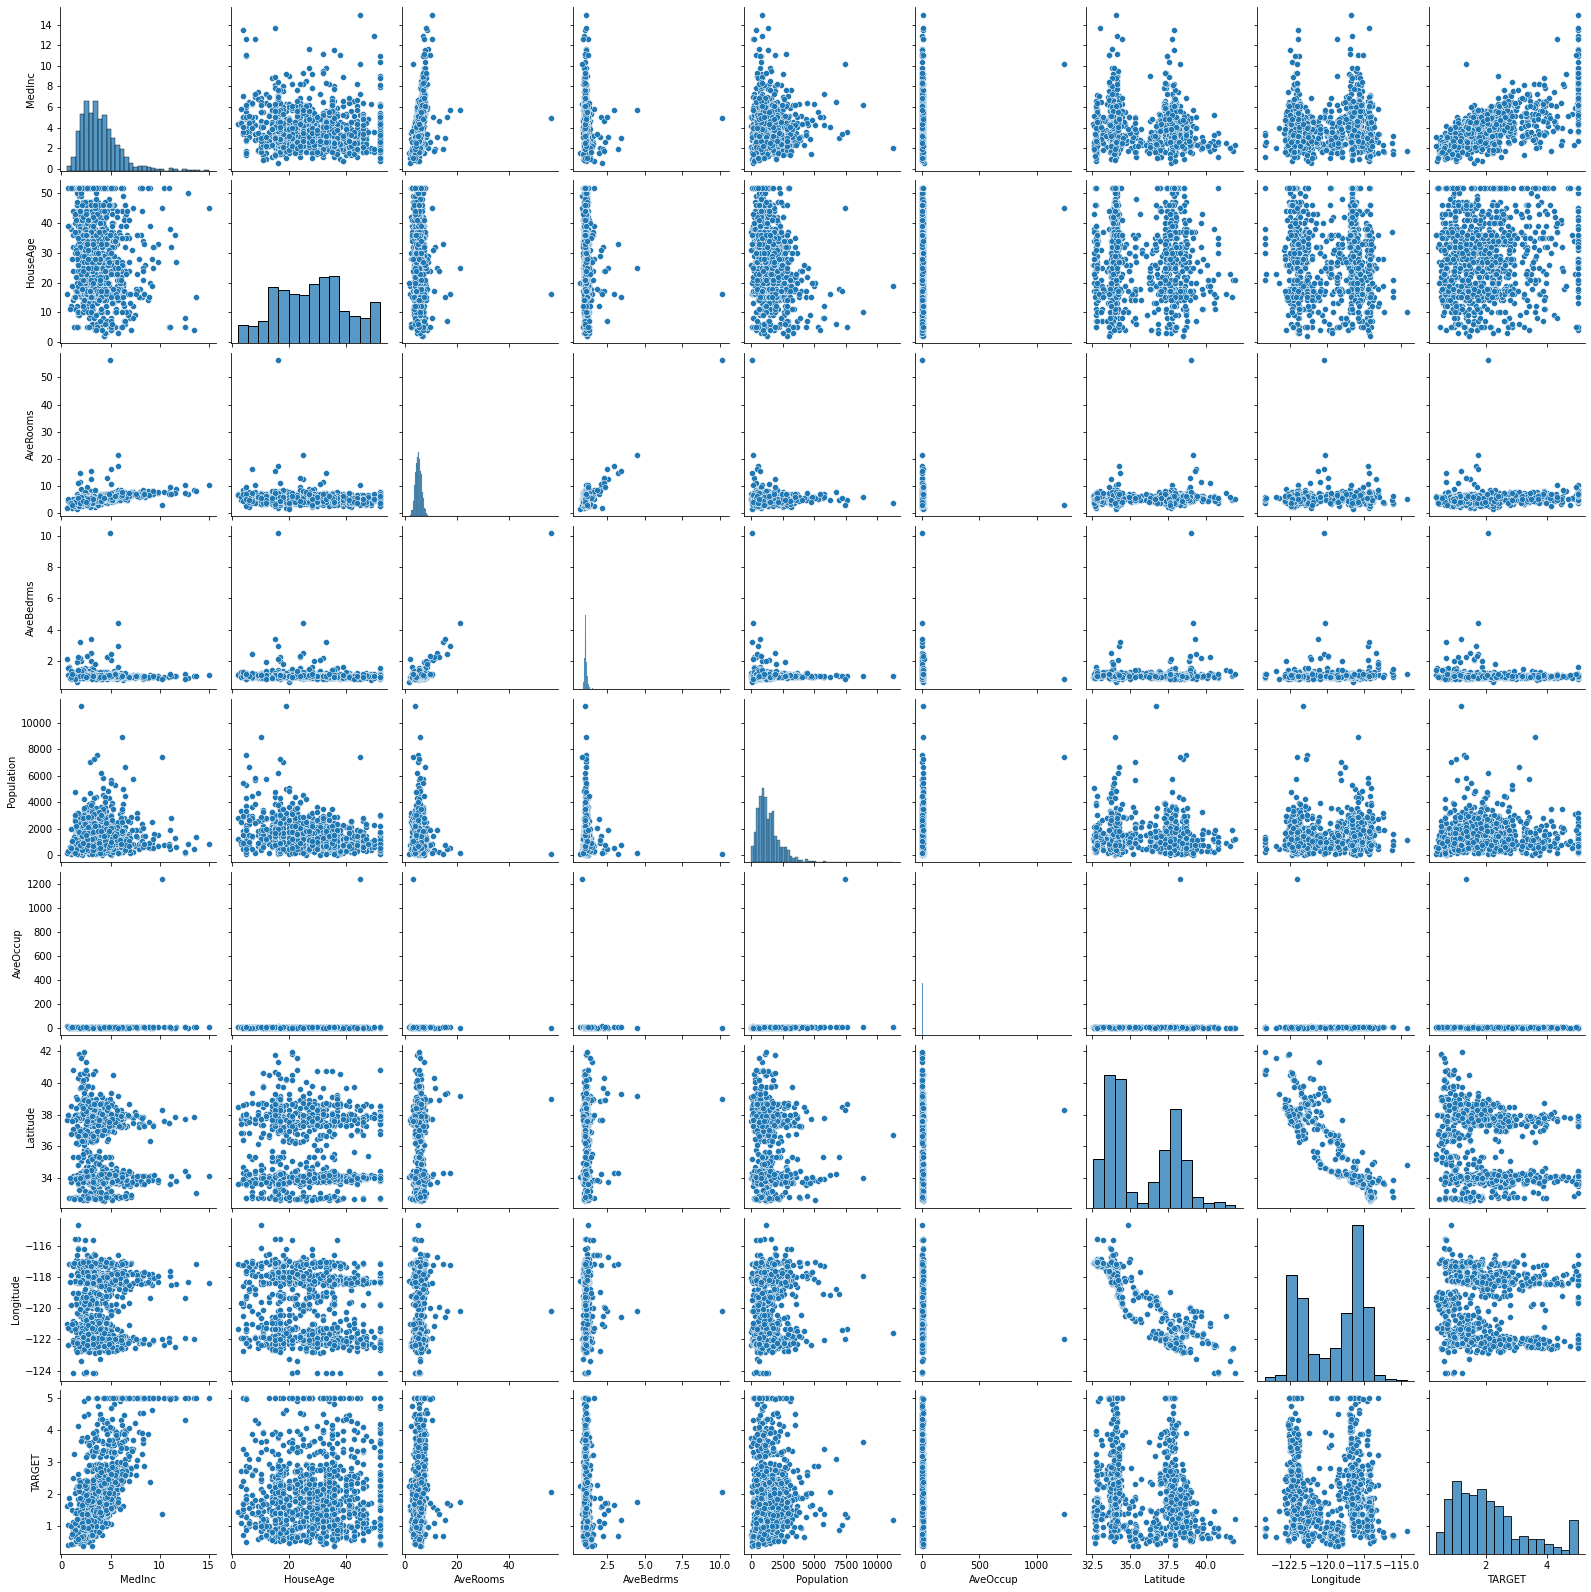

In [2]:
# 데이터 분포 파악 (pairplot)

sns.pairplot(df.sample(1000))
plt.show()

# 데이터 분포를 보면 봉우리가 여러개인 멀티 모달이 확인된다.
# 일괄적으로 표준 스케일링 적용

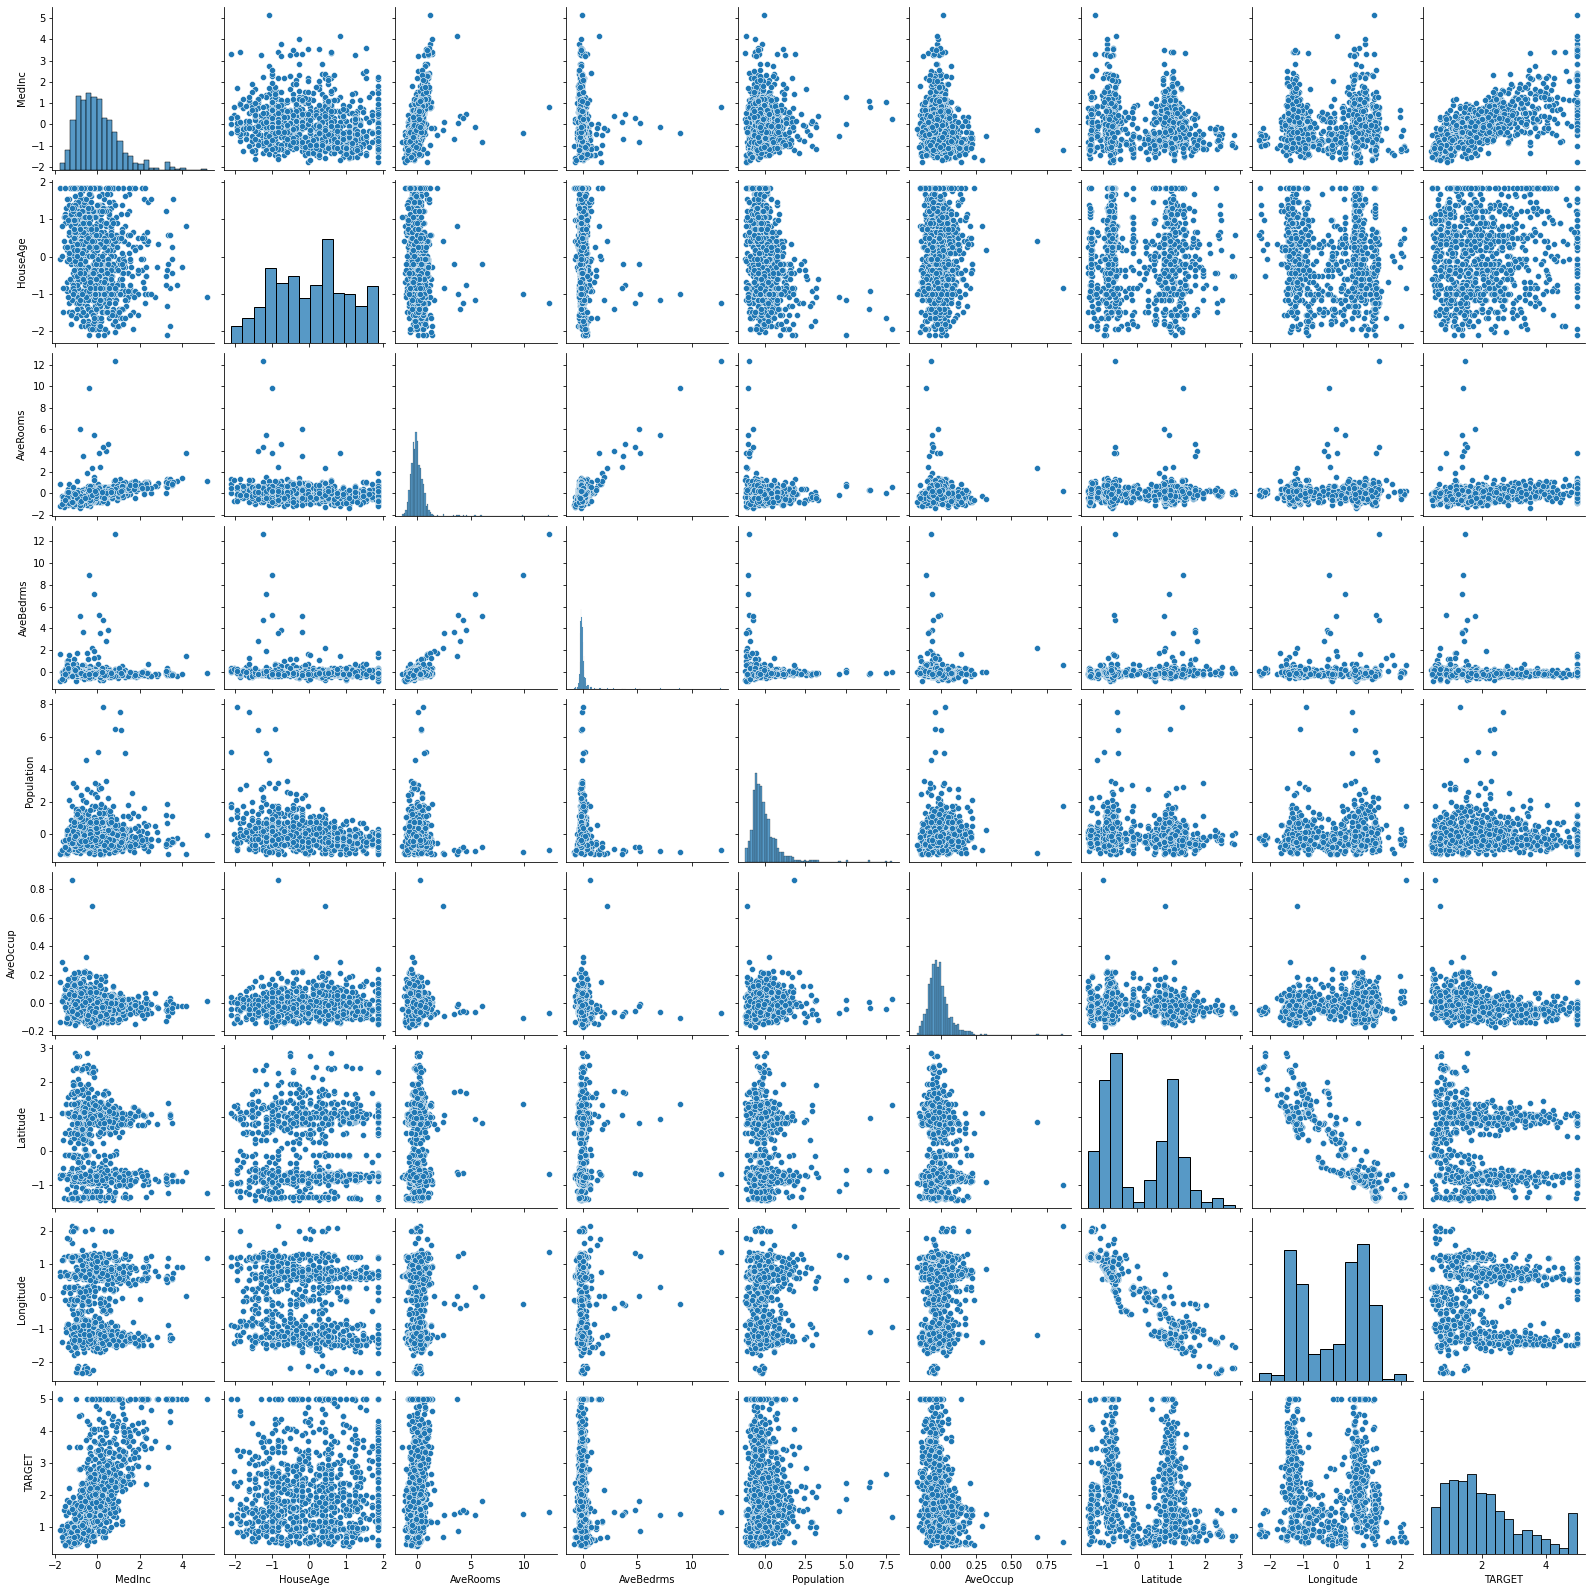

In [4]:
# 최적화를 위한 표준 스케일링 수행

scaler = StandardScaler()
scaler.fit(df.values[:, :-1])
df.values[:, : -1] = scaler.transform(df.values[:, :-1])

sns.pairplot(df.sample(1000))
plt.show()

# 이렇게 최적화를 수행하는 이유는 colums마다 단위가 다르기 때문이다.
# 정규화전에 데이터셋의 분포의 특징을 파악하고 어떤 정규화 방법이 가장 좋을지 결정해야한다.

### 2. 학습 코드 구현

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Numpy 데이터를 파이토치 실수형 텐서로 변환

data = torch.from_numpy(df.values).float()

# 입력 x와 출력 y로 나눈기

x = data[:, :-1]
y = data[:, -1:]
print(x.shape, y.shape)

# 학습에 필요한 설정값을 정한다.

n_epochs = 4000
batch_size = 256
learning_late = 1e-2
print_interval = 200

torch.Size([20640, 8]) torch.Size([20640, 1])


- DNN을 nn.Sequential로 정의한다.

In [6]:
# nn.Sequential

model = nn.Sequential(
    nn.Linear(x.size(-1), 6), # 첫 번째 선형 계층의 크기 8
    nn.LeakyReLU(),
    nn.Linear(6,5),
    nn.LeakyReLU(),
    nn.Linear(5,4),
    nn.LeakyReLU(),
    nn.Linear(4,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1)) # 마지막 선형 계층의 크기 1
)

print(model)

Sequential(
  (0): Linear(in_features=8, out_features=6, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=6, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=4, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=4, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [7]:
# optimizer 선언

optimizer = optim.SGD(model.parameters(), lr = learning_late)

In [9]:
# 학습 수행

for i in range(n_epochs):
    # Shuffle the index to feed-forward
    indices = torch.randperm(x.size(0))
    x_ = torch.index_select(x, dim = 0, index = indices)
    y_ = torch.index_select(y, dim = 0, index = indices)

    x_ = x_.split(batch_size, dim = 0)
    y_ = y_.split(batch_size, dim = 0)

    y_hat = []
    total_loss = 0

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = F.mse_loss(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

        total_loss += float(loss) # 메모리 부족을 방지하기 위하여 중요한 부분이다.

        y_hat += [y_hat_i]
        total_loss = total_loss / len(x_)

    if (i+1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, total_loss))

y_hat = torch.cat(y_hat, dim = 0)
y = torch.cat(y_, dim = 0)

Epoch 200: loss=1.6135e-02
Epoch 400: loss=1.4544e-02
Epoch 600: loss=1.7858e-02
Epoch 800: loss=2.0440e-02
Epoch 1000: loss=1.6198e-02
Epoch 1200: loss=1.5468e-02
Epoch 1400: loss=1.7624e-02
Epoch 1600: loss=1.5733e-02
Epoch 1800: loss=1.6653e-02
Epoch 2000: loss=1.2954e-02
Epoch 2200: loss=1.3381e-02
Epoch 2400: loss=1.7783e-02
Epoch 2600: loss=1.7349e-02
Epoch 2800: loss=1.7497e-02
Epoch 3000: loss=1.9548e-02
Epoch 3200: loss=1.5191e-02
Epoch 3400: loss=1.9344e-02
Epoch 3600: loss=1.7162e-02
Epoch 3800: loss=1.4407e-02
Epoch 4000: loss=1.7647e-02


### 3. 결과 확인
- 분류 문제이므로 분류 예측 결과에 대한 정확도 평가가 가능하다

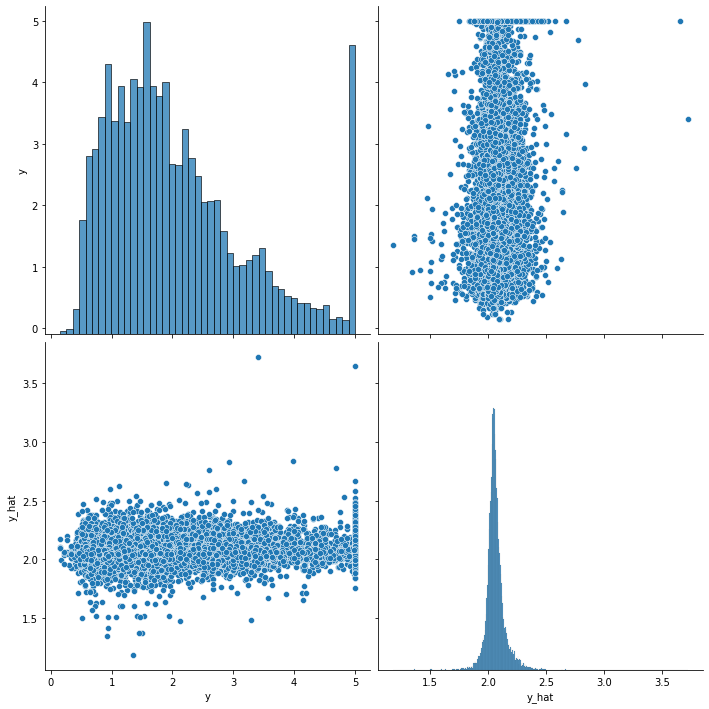

In [10]:
df = pd.DataFrame(torch.cat([y, y_hat], dim = 1).detach_().numpy(),
                  columns = ['y', 'y_hat'])

sns.pairplot(df, height = 5)
plt.show()

# 실제 값과 유사한 분포를 보여주고있다.

## 10.5 마치며

### 요약

1. SGD
 - SGD는 비복원 추출을 통해 일부 샘플을 뽑아 미니배치를 구성하고 피드포워딩 및 파라미터를 업데이트하는 방법
 - 기존 전체 데이터셋을 활용하는 방식에 비해 파라미터 업데이트를 효율적으로 수행 할 수 있다.

2. 용어 설명
 - epoch : 모델이 데이터 전체를 학습하는 것
 - iteration : 모델의 파라미터 업데이트를 1회 수행하는 것

3. 미니배치 크기에 따른 특징
 - 미니배치가 작을수록 한 에포크 내에서 파라미터를 업데이트하는 횟수가 증가
 - 미니배치가 클수록 그래디언트에 노이즈가 줄어든다.
 - 메모리가 허용하는 한에서 큰 미니배치를 사용하면 좋다.
 - 미니배치 크기는 $2^n$형태로 정해주는 것이 속도에 유리하다.